# **Machine Learning Project: Saudi Arabia Used Cars**

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regression
from sklearn.impute import KNNImputer # KNN regression

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

# feature selection
from sklearn.feature_selection import SelectKBest

# algorithm
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# metric
from sklearn.metrics import mean_absolute_error as mae, r2_score
from statsmodels.tools.eval_measures import rmse

# resampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as imb_Pipeline

# ensemble models
from sklearn.ensemble import VotingRegressor, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

# pickle
import pickle

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## **Initial Dataset**

In [8]:
df = pd.read_csv('data_saudi_used_cars_raw.csv')
df

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0
...,...,...,...,...,...,...,...,...,...,...,...
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5620,Altima,Jeddah,Nissan,Automatic,Saudi,Semi Full,2020,2.5,58000,True,0
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000
5622,RX,Dammam,Lexus,Automatic,Gulf Arabic,Full,2016,2.5,81000,False,154000


## **Data Cleaning**

### **1. Duplicate Data**
Since these duplicated data can affect the modeling process, we will be deleting them.

In [9]:
df.duplicated().sum()

4

In [10]:
df = df.drop_duplicates()
df

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0
...,...,...,...,...,...,...,...,...,...,...,...
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5620,Altima,Jeddah,Nissan,Automatic,Saudi,Semi Full,2020,2.5,58000,True,0
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000
5622,RX,Dammam,Lexus,Automatic,Gulf Arabic,Full,2016,2.5,81000,False,154000


### **2. Null Values**
Null values can also affect the modeling process. Depending on the null values, we will either delete them, or impute them with values.

In [11]:
df.isna().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

There are no null values found. We will continue to define the business problem.

## **Business Problem**
A business on used cars in Saudi Arabia requires being able to sell used cars at a reasonable price, and there are many factors that come into play when determining the price of used cars. Can we develop a machine learning model that can accurately predict the optimal listing price for used cars based on the various attributes that are given above, in order to maximise our profits?

## **Approach**
This problem can be solved in several parts: 
1. Firstly, we will need to analyse the data given above, determine the presence of extreme outliers in the data, and analyse the correlation between the features and target. 
2. Afterwards, we will create a regression model using the best possible algorithm, so that this model can be used by the business to estimate the most reasonable price of a used car.

### **Metrics of Evaluation**
There are many metrics of evaluation available to test the accuracy of our machine learning model. In this case, we will be using 3 metrics:
1. **RMSE** (Root Mean Squared Error) - this is used to indicate the **magnitude of error** in our regression model.
2. **MAE** - Mean Absolute Error - this is used to indicate the **difference in price** between our predicted values and the actual values.
3. **R-squared Score** - this is used to determine the **overall fit** of our regression model.

## **EDA**
We will be analysing only the numerical information in the data, to check their distribution and presence of outliers.

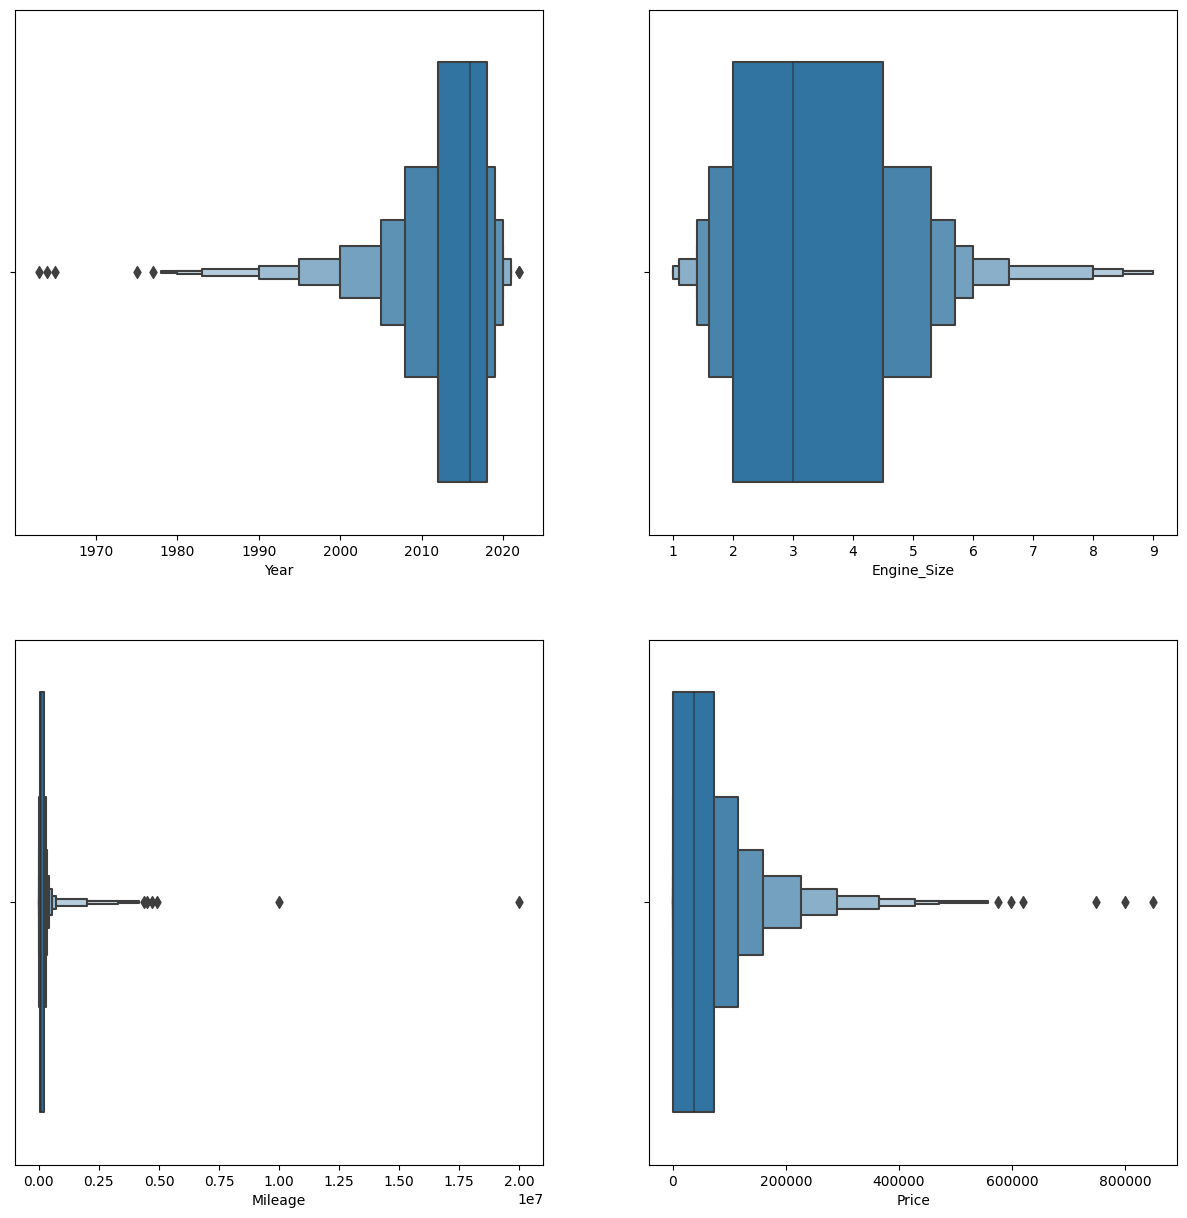

In [12]:
plt.figure(figsize=(15,15))
pltnum = 1
for column in df.describe().columns:
    plt.subplot(2,2,pltnum)
    sns.boxenplot(data=df, x=column)
    pltnum += 1

As seen above, there are a large number of outliers in the numerical features.<br>
Focusing on the feature **"Mileage"**, there are only 2 values that are extremely far from the distribution of data.<br>
We will be deleting these 2 outliers, as they can also impact our model and are considered insignificant to the data.

In [13]:
df = df[df['Mileage']<0.75e7]
df

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0
...,...,...,...,...,...,...,...,...,...,...,...
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5620,Altima,Jeddah,Nissan,Automatic,Saudi,Semi Full,2020,2.5,58000,True,0
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000
5622,RX,Dammam,Lexus,Automatic,Gulf Arabic,Full,2016,2.5,81000,False,154000


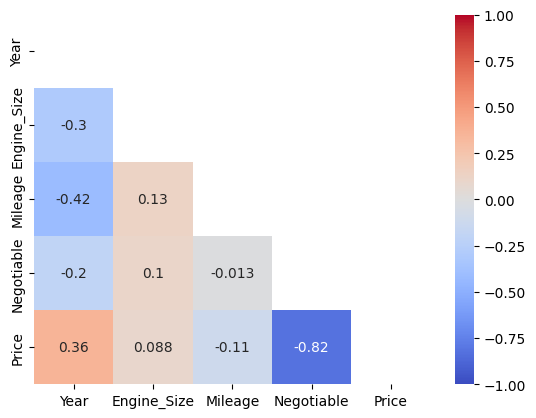

In [14]:
matrix = df.corr(numeric_only=True, method='spearman')
sns.heatmap(data=matrix,
            annot=True, # Annotates the numbers in the heatmap
            cmap= 'coolwarm', # Changes color of heatmap. Colors given in the seaborn function.
            center=0, # Becomes white the closer the value is to 0.
            mask=np.triu(matrix), # Removes the "double" values in the heatmap.
            vmin = -1, # At value = -1, color is Blue.
            vmax = 1 # At value = 1, color is Red.
            );

Correlation is relatively weak across all features, except Negotiable and Price.

## **Defining Features (X) and Target (y)**

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5618 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5618 non-null   object 
 1   Region       5618 non-null   object 
 2   Make         5618 non-null   object 
 3   Gear_Type    5618 non-null   object 
 4   Origin       5618 non-null   object 
 5   Options      5618 non-null   object 
 6   Year         5618 non-null   int64  
 7   Engine_Size  5618 non-null   float64
 8   Mileage      5618 non-null   int64  
 9   Negotiable   5618 non-null   bool   
 10  Price        5618 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 488.3+ KB


**Additional Information:** The column 'Options' describe whether the interiors are modified or not.
- standard: no modifications
- semi full: partly modified
- full : fully modified

In [16]:
x = df.drop(columns='Price')
y = df['Price']
display(x.head())
y.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True


0         0
1    120000
2    260000
3     42000
4         0
Name: Price, dtype: int64

## **Data Splitting**
We will split the data into two:
- **the training set**, the data which the model will learn from, and
- **the testing set**, the data to test the accuracy of our model.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

## **Preprocessing**

In [18]:
# Checking for number of unique values in each column
for column in df.select_dtypes(['object']).columns:
    print(f"{column}: {df[column].nunique()}")

Type: 347
Region: 27
Make: 58
Gear_Type: 2
Origin: 4
Options: 3


In [19]:
df['Options'].unique()

array(['Standard', 'Full', 'Semi Full'], dtype=object)

In preprocessing, we will be handling:
1. **Missing Values.** Since there are no missing values, we can skip this process.
2. **Encoding.** The model can only work with numerical features, and as such, categorical features need to be converted into numerical features.
    - Binary Encoding will be required for columns: Type, Region, Make
    - One Hot Encoding will be required for columns: Gear_Type, Origin, Negotiable
    - Ordinal Encoding will be required for columns: Options
3. **Scaling.** Since the range of numerical values are extremely large, we will be scaling them to improve our model's accuracy.
    - Robust Scaling will be required for all numerical columns.

In [4]:
encoder = [{
    'col':'Options',
    'mapping':{
        'Standard':1,
        'Semi Full':2,
        'Full':3
    }
}]

transformer = ColumnTransformer([
    ('binary', BinaryEncoder(), ['Type', 'Region', 'Make']),
    ('onehot', OneHotEncoder(), ['Gear_Type', 'Origin', 'Negotiable']),
    ('ordinal', OrdinalEncoder(cols=['Options'], mapping=encoder), ['Options']),
    ('robust', RobustScaler(), ['Year','Engine_Size','Mileage'])
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('binary', BinaryEncoder(),
                                 ['Type', 'Region', 'Make']),
                                ('onehot', OneHotEncoder(),
                                 ['Gear_Type', 'Origin', 'Negotiable']),
                                ('ordinal',
                                 OrdinalEncoder(cols=['Options'],
                                                mapping=[{'col': 'Options',
                                                          'data_type': dtype('O'),
                                                          'mapping': Standard     1
Semi Full    2
Full         3
dtype: int64}]),
                                 ['Options']),
                                ('robust', RobustScaler(),
                                 ['Year', 'Engine_Size', 'Mileage'])])

## **Model Cross-Validation**

There are several algorithms that we will be using for our machine learning model. <br>
We will test each of these and determine which one is the most accurate algorithm.
1. Ridge
2. Lasso
3. DecisionTreeRegressor
4. KNeighborsRegressor
5. Ensemble Models:
    - RandomForestRegressor
    - BaggingRegressor
    - VotingRegressor
    - AdaBoostRegressor
    - XGBoostRegressor

As explained above, the metrics to test our algorithms will be:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- R-squared (R2 Score)

In [16]:
# base models
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
tree = DecisionTreeRegressor(random_state=42)
knn = KNeighborsRegressor()

# ensemble models
rf = RandomForestRegressor(random_state=42)
adb = AdaBoostRegressor(random_state=42)
xgb = XGBRegressor()

voting = VotingRegressor([
    ('reg1', ridge),
    ('reg2', lasso),
    ('reg3', tree),
    ('reg4', knn)
])

bagging = BaggingRegressor(
    random_state = 42,
    estimator = knn
)

In [17]:
skfold = StratifiedKFold(n_splits=5)
list_models = [ridge, lasso, tree, knn, rf, adb, xgb, voting, bagging]
list_metrics = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

for metric in list_metrics:
    
    cv_mean = []
    cv_std = []
    
    for model in list_models:
        
        model_pipe = Pipeline([
            ('preprocessing', transformer),
            ('modeling', model)
        ])
        
        model_cv = cross_val_score(
            estimator = model_pipe,
            X = x_train,
            y = y_train,
            cv = skfold,
            scoring = metric
        )
        
        cv_mean.append(model_cv.mean())
        cv_std.append(model_cv.std())
        
    df_cv = pd.DataFrame({
    'models':list_models,
    'mean':cv_mean,
    'std':cv_std,
    })
        
    print(f"Metric used: {metric}")
    display(df_cv.sort_values('mean', ascending=False))
    print('====================================')

Metric used: neg_mean_absolute_error


,models,mean,std
4,RandomForestRegressor(random_state=42),-13102.682286,1177.577632
6,"XGBRegressor(base_score=None, booster=None, ca...",-14162.042481,850.807585
2,DecisionTreeRegressor(random_state=42),-17489.691778,1345.633184
8,BaggingRegressor(estimator=KNeighborsRegressor...,-19868.985772,693.428716
3,KNeighborsRegressor(),-19932.572656,645.191756
7,"VotingRegressor(estimators=[('reg1', Ridge(ran...",-21638.239686,448.021119
0,Ridge(random_state=42),-31720.642507,527.605286
1,Lasso(random_state=42),-31727.977348,527.291687
5,AdaBoostRegressor(random_state=42),-55382.096465,4145.040715


Metric used: neg_root_mean_squared_error


,models,mean,std
6,"XGBRegressor(base_score=None, booster=None, ca...",-29125.924642,3305.353441
4,RandomForestRegressor(random_state=42),-30792.970233,4782.523125
7,"VotingRegressor(estimators=[('reg1', Ridge(ran...",-38332.086029,2971.472832
8,BaggingRegressor(estimator=KNeighborsRegressor...,-38498.432242,3630.677517
3,KNeighborsRegressor(),-39204.946575,3875.274853
2,DecisionTreeRegressor(random_state=42),-41818.277483,4849.079091
0,Ridge(random_state=42),-51891.689366,1581.811240
1,Lasso(random_state=42),-51893.703812,1581.521372
5,AdaBoostRegressor(random_state=42),-65293.761344,3714.748349


Metric used: r2


,models,mean,std
6,"XGBRegressor(base_score=None, booster=None, ca...",0.827674,0.035659
4,RandomForestRegressor(random_state=42),0.805301,0.054554
7,"VotingRegressor(estimators=[('reg1', Ridge(ran...",0.703665,0.033924
8,BaggingRegressor(estimator=KNeighborsRegressor...,0.701070,0.040709
3,KNeighborsRegressor(),0.689941,0.044802
2,DecisionTreeRegressor(random_state=42),0.642403,0.081309
0,Ridge(random_state=42),0.457681,0.011489
1,Lasso(random_state=42),0.457640,0.011458
5,AdaBoostRegressor(random_state=42),0.133498,0.128868


The best model here is XGBRegressor, because:
1. It has the lowest errors compared to other models (lowest RMSE)
2. Second lowest MAE compared to other model
    - difference of MAE between XGB and RandomForest is relatively insignificant
3. It has the highest R-squared value compared to other models (best-fit model)
<br>
We will now get to:

## **Hyperparameter Tuning**

### **Modeling before Tuning**

In [81]:
# modeling
model_pretuned = Pipeline([
    ('preprocessing', transformer),
    ('modeling', xgb)
])

# fitting
model_pretuned.fit(x_train, y_train)

# predicting
y_pred = model_pretuned.predict(x_test)

# metrics
print(f"MAE before tuning: {mae(y_pred, y_test)}")
print(f"RMSE before tuning: {rmse(y_pred, y_test)}")
print(f"R-squared before tuning: {r2_score(y_pred, y_test)}")

MAE before tuning: 13747.139193100436
RMSE before tuning: 27867.621584443048
R-squared before tuning: 0.8123474151949536


### **Tuning**

In [82]:
params = {
    'modeling__n_estimators': [100,500,1000],
    'modeling__learning_rate': [0.01,0.1,0.3],
    'modeling__max_depth': [3,6,9,12],
    'modeling__min_child_weight': [1,5,10],
    'modeling__subsample': [0.6,0.8,1.0]
}

gridsearch_rmse = GridSearchCV(
    estimator = model_pretuned,
    param_grid = params,
    cv = skfold,
    n_jobs = -1,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2
)
gridsearch_rmse

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('binary',
                                                                         BinaryEncoder(),
                                                                         ['Type',
                                                                          'Region',
                                                                          'Make']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Gear_Type',
                                                                          'Origin',
                                                                          'Negotiable']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(cols=['Options'],
                                                                                        mapping=[{'col': '...
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'modeling__learning_rate': [0.01, 0.1, 0.3],
                         'modeling__max_depth': [3, 6, 9, 12],
                         'modeling__min_child_weight': [1, 5, 10],
                         'modeling__n_estimators': [100, 500, 1000],
                         'modeling__subsample': [0.6, 0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [83]:
gridsearch_rmse.fit(x_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('binary',
                                                                         BinaryEncoder(),
                                                                         ['Type',
                                                                          'Region',
                                                                          'Make']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Gear_Type',
                                                                          'Origin',
                                                                          'Negotiable']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(cols=['Options'],
                                                                                        mapping=[{'col': '...
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'modeling__learning_rate': [0.01, 0.1, 0.3],
                         'modeling__max_depth': [3, 6, 9, 12],
                         'modeling__min_child_weight': [1, 5, 10],
                         'modeling__n_estimators': [100, 500, 1000],
                         'modeling__subsample': [0.6, 0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [84]:
gridsearch_rmse.best_params_

{'modeling__learning_rate': 0.01,
 'modeling__max_depth': 12,
 'modeling__min_child_weight': 10,
 'modeling__n_estimators': 1000,
 'modeling__subsample': 0.8}

In [89]:
gridsearch_mae = GridSearchCV(
    estimator = model_pretuned,
    param_grid = params,
    cv = skfold,
    n_jobs = -1,
    scoring = 'neg_mean_absolute_error',
    verbose = 2
)
gridsearch_mae

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('binary',
                                                                         BinaryEncoder(),
                                                                         ['Type',
                                                                          'Region',
                                                                          'Make']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Gear_Type',
                                                                          'Origin',
                                                                          'Negotiable']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(cols=['Options'],
                                                                                        mapping=[{'col': '...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'modeling__learning_rate': [0.01, 0.1, 0.3],
                         'modeling__max_depth': [3, 6, 9, 12],
                         'modeling__min_child_weight': [1, 5, 10],
                         'modeling__n_estimators': [100, 500, 1000],
                         'modeling__subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [90]:
gridsearch_mae.fit(x_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('binary',
                                                                         BinaryEncoder(),
                                                                         ['Type',
                                                                          'Region',
                                                                          'Make']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Gear_Type',
                                                                          'Origin',
                                                                          'Negotiable']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(cols=['Options'],
                                                                                        mapping=[{'col': '...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'modeling__learning_rate': [0.01, 0.1, 0.3],
                         'modeling__max_depth': [3, 6, 9, 12],
                         'modeling__min_child_weight': [1, 5, 10],
                         'modeling__n_estimators': [100, 500, 1000],
                         'modeling__subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [91]:
gridsearch_mae.best_params_

{'modeling__learning_rate': 0.01,
 'modeling__max_depth': 12,
 'modeling__min_child_weight': 1,
 'modeling__n_estimators': 500,
 'modeling__subsample': 0.6}

In [86]:
gridsearch_r2 = GridSearchCV(
    estimator = model_pretuned,
    param_grid = params,
    cv = skfold,
    n_jobs = -1,
    scoring = 'r2',
    verbose = 2
)
gridsearch_r2

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('binary',
                                                                         BinaryEncoder(),
                                                                         ['Type',
                                                                          'Region',
                                                                          'Make']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Gear_Type',
                                                                          'Origin',
                                                                          'Negotiable']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(cols=['Options'],
                                                                                        mapping=[{'col': '...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'modeling__learning_rate': [0.01, 0.1, 0.3],
                         'modeling__max_depth': [3, 6, 9, 12],
                         'modeling__min_child_weight': [1, 5, 10],
                         'modeling__n_estimators': [100, 500, 1000],
                         'modeling__subsample': [0.6, 0.8, 1.0]},
             scoring='r2', verbose=2)

In [87]:
gridsearch_r2.fit(x_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('binary',
                                                                         BinaryEncoder(),
                                                                         ['Type',
                                                                          'Region',
                                                                          'Make']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Gear_Type',
                                                                          'Origin',
                                                                          'Negotiable']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(cols=['Options'],
                                                                                        mapping=[{'col': '...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'modeling__learning_rate': [0.01, 0.1, 0.3],
                         'modeling__max_depth': [3, 6, 9, 12],
                         'modeling__min_child_weight': [1, 5, 10],
                         'modeling__n_estimators': [100, 500, 1000],
                         'modeling__subsample': [0.6, 0.8, 1.0]},
             scoring='r2', verbose=2)

In [88]:
gridsearch_r2.best_params_

{'modeling__learning_rate': 0.01,
 'modeling__max_depth': 12,
 'modeling__min_child_weight': 10,
 'modeling__n_estimators': 1000,
 'modeling__subsample': 0.8}

In [92]:
df_grids = pd.DataFrame([gridsearch_rmse.best_params_, 
                         gridsearch_mae.best_params_,
                         gridsearch_r2.best_params_], 
                        index=['gridsearch_rmse','gridsearch_mae','gridsearch_r2'])
df_grids = df_grids.reset_index().rename(columns={'index':'scoring'})
df_grids

,scoring,modeling__learning_rate,modeling__max_depth,modeling__min_child_weight,modeling__n_estimators,modeling__subsample
0,gridsearch_rmse,0.01,12,10,1000,0.8
1,gridsearch_mae,0.01,12,1,500,0.6
2,gridsearch_r2,0.01,12,10,1000,0.8


### **Modeling after Tuning**

In [23]:
# tuned algorithm
xgbtuned = XGBRegressor(learning_rate=0.01, max_depth=12, min_child_weight=10, n_estimators=1000, subsample=0.8)

# tuned model
model_tuned = Pipeline([
    ('preprocessing', transformer),
    ('modeling', xgbtuned)
])

# fitting
model_tuned.fit(x_train, y_train)

# predicting
y_pred_tuned = model_tuned.predict(x_test)

# rmse and R2
print(f"MAE after tuning: {mae(y_pred_tuned, y_test)}")
print(f"RMSE after tuning: {rmse(y_pred_tuned, y_test)}")
print(f"R-squared after tuning: {r2_score(y_pred_tuned, y_test)}")

MAE after tuning: 11803.25724678574
RMSE after tuning: 26988.559316068084
R-squared after tuning: 0.8193392548036116


#### **Results:**
1. MAE has decreased from **13,747** to **11,803** after the model is tuned.
2. RMSE has decreased from **27,867** to **26,988** after the model is tuned.
3. R-squared value has increased from **0.8123** to **0.8193** after the model is tuned.<br>
<br>
Therefore, tuning has improved the model's performance.

## **Feature Selection**

Firstly, transformation of the variable X is required for feature selection.

In [19]:
# fit
transformer.fit(x_train)

# transform
x_train_prep = transformer.transform(x_train)
x_test_prep = transformer.transform(x_test)

# dataframes for transformed X
df_x_train_prep = pd.DataFrame(x_train_prep, columns=transformer.get_feature_names_out())
display(df_x_train_prep.head())
df_x_test_prep = pd.DataFrame(x_test_prep, columns=transformer.get_feature_names_out())
df_x_test_prep.head()

,binary__Type_0,binary__Type_1,binary__Type_2,binary__Type_3,binary__Type_4,binary__Type_5,binary__Type_6,binary__Type_7,binary__Type_8,binary__Region_0,...,onehot__Origin_Gulf Arabic,onehot__Origin_Other,onehot__Origin_Saudi,onehot__Origin_Unknown,onehot__Negotiable_False,onehot__Negotiable_True,ordinal__Options,robust__Year,robust__Engine_Size,robust__Mileage
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.333333,-0.20,-0.099145
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.500000,-0.40,-0.440576
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,3.0,-0.166667,0.20,-0.030983
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.08,1.530554
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.333333,1.36,-0.111538


,binary__Type_0,binary__Type_1,binary__Type_2,binary__Type_3,binary__Type_4,binary__Type_5,binary__Type_6,binary__Type_7,binary__Type_8,binary__Region_0,...,onehot__Origin_Gulf Arabic,onehot__Origin_Other,onehot__Origin_Saudi,onehot__Origin_Unknown,onehot__Negotiable_False,onehot__Negotiable_True,ordinal__Options,robust__Year,robust__Engine_Size,robust__Mileage
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.166667,-0.40,0.030983
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.166667,-0.56,0.012393
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,2.0,-0.166667,-0.40,-0.347008
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.666667,0.20,1.109187
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.166667,-0.20,0.452350


In [20]:
# model
xgb_final = xgbtuned

# fit
xgb_final.fit(x_train_prep, y_train)

# feature importances in dataframe
df_imp = pd.DataFrame({
    'feature':transformer.get_feature_names_out(),
    'importance':xgb_final.feature_importances_
})
df_imp.sort_values('importance', ascending=False, inplace=True)
display(df_imp)

,feature,importance
26,onehot__Negotiable_False,0.435156
28,ordinal__Options,0.077248
19,binary__Make_5,0.068869
29,robust__Year,0.054137
15,binary__Make_1,0.049362
30,robust__Engine_Size,0.046824
16,binary__Make_2,0.046546
17,binary__Make_3,0.036147
6,binary__Type_6,0.018652
14,binary__Make_0,0.017734


Importance values range from **0** to **0.4351**. 

In [21]:
# dataframes for transformed X
df_x_train_prep = pd.DataFrame(x_train_prep, columns=transformer.get_feature_names_out())
df_x_test_prep = pd.DataFrame(x_test_prep, columns=transformer.get_feature_names_out())

# bad features (features with importance < 0.005)
bad_features = df_imp[df_imp['importance']<0.005]['feature']

# modifying dataframe
df_x_train_prep = df_x_train_prep.drop(columns=bad_features)
df_x_test_prep = df_x_test_prep.drop(columns=bad_features)

# fit, predict
xgb_final.fit(df_x_train_prep, y_train)
y_pred_good = xgb_final.predict(df_x_test_prep)

# RMSE, R-squared
print(f"MAE after removal of features: {mae(y_pred_good, y_test)}")
print(f'RMSE after removal of features: {rmse(y_pred_good, y_test)}')
print(f'R-squared after removal of features: {r2_score(y_pred_good, y_test)}')

MAE after removal of features: 11902.615384657081
RMSE after removal of features: 27170.898727912903
R-squared after removal of features: 0.8161822588237347


### **SelectKBest Feature Selection**

In [22]:
len(df_x_train_prep.columns)

27

There are 26 features in total. Hence the maximum number of k-value is 26.

In [23]:
list_kval = range(13,27)
list_rmse = []
list_mae = []
list_r2 = []

for k in list_kval:
    # Selection Model
    select = SelectKBest(k=k)
    
    # fit
    select.fit(df_x_train_prep, y_train)
    
    # transform
    x_train_select = select.transform(df_x_train_prep)
    x_test_select = select.transform(df_x_test_prep)
    
    # modeling
    xgb_final.fit(x_train_select, y_train)
    
    # predicting
    y_pred_good = xgb_final.predict(x_test_select)
    
    # rmse and r2
    rmse_val = rmse(y_pred_good, y_test)
    r2 = r2_score(y_pred_good, y_test)
    mae_val = mae(y_pred_good, y_test)
    
    # append to list
    list_rmse.append(rmse_val)
    list_mae.append(mae_val)
    list_r2.append(r2)
    
df_ktest = pd.DataFrame({
    'k':list_kval,
    'rmse':list_rmse,
    'mae':list_mae,
    'r2':list_r2
})
df_ktest

,k,rmse,mae,r2
0,13,32823.752276,13848.752436,0.718204
1,14,31612.405950,13227.684967,0.736757
2,15,31651.892286,13075.434384,0.737216
3,16,29916.457402,12625.499533,0.766421
4,17,29708.746890,12510.404300,0.769605
5,18,29390.218202,12397.425043,0.776745
6,19,29591.048214,12522.172409,0.774621
7,20,29571.743527,12538.787804,0.773870
8,21,29494.150996,12477.118262,0.776833
9,22,29436.385172,12487.698644,0.776962


Based on model-based feature selection and SelectKBest feature selection,
1. RMSE **increases** from 26,988 to 28,267.
2. MAE **increases** from 11,803 to 12,154.
3. R-squared **decreases** from 0.8193 to 0.8048.<br>
<br>
Therefore, feature selection is **not required.** All of the features in the dataset helps build a more accurate model.

## **Visualisation**

In [24]:
# tuned algorithm
xgbtuned = XGBRegressor(learning_rate=0.01, max_depth=9, min_child_weight=10, n_estimators=1000, subsample=0.8)

# tuned model
model_tuned = Pipeline([
    ('preprocessing', transformer),
    ('modeling', xgbtuned)
])

# fitting
model_tuned.fit(x_train, y_train)

# predicting
y_pred_tuned = model_tuned.predict(x_test)

# error
error = y_test - y_pred_tuned

### **1. Actual vs Predicted**

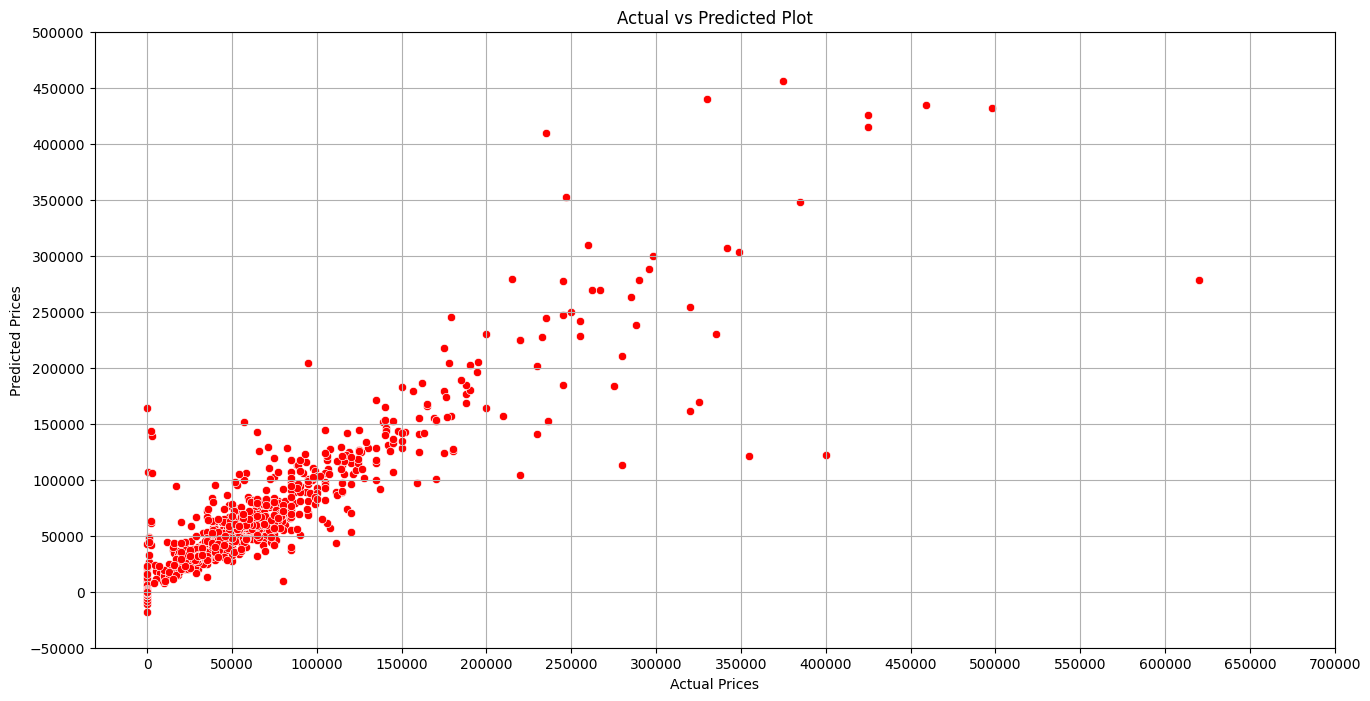

In [25]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=y_test, y=y_pred_tuned, color='r')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Plot')
plt.xticks(range(0,700001,50000))
plt.yticks(range(-50000,500001,50000))
plt.grid(True);

#### **Insights:**
1. The predicted prices generally follow the actual prices. This indicates that the model's performance is good.
2. The model is more accurate at lower prices than higher prices. 
    - At prices above $200,000, there is an increase in errors.

### **2. Residual Plot**

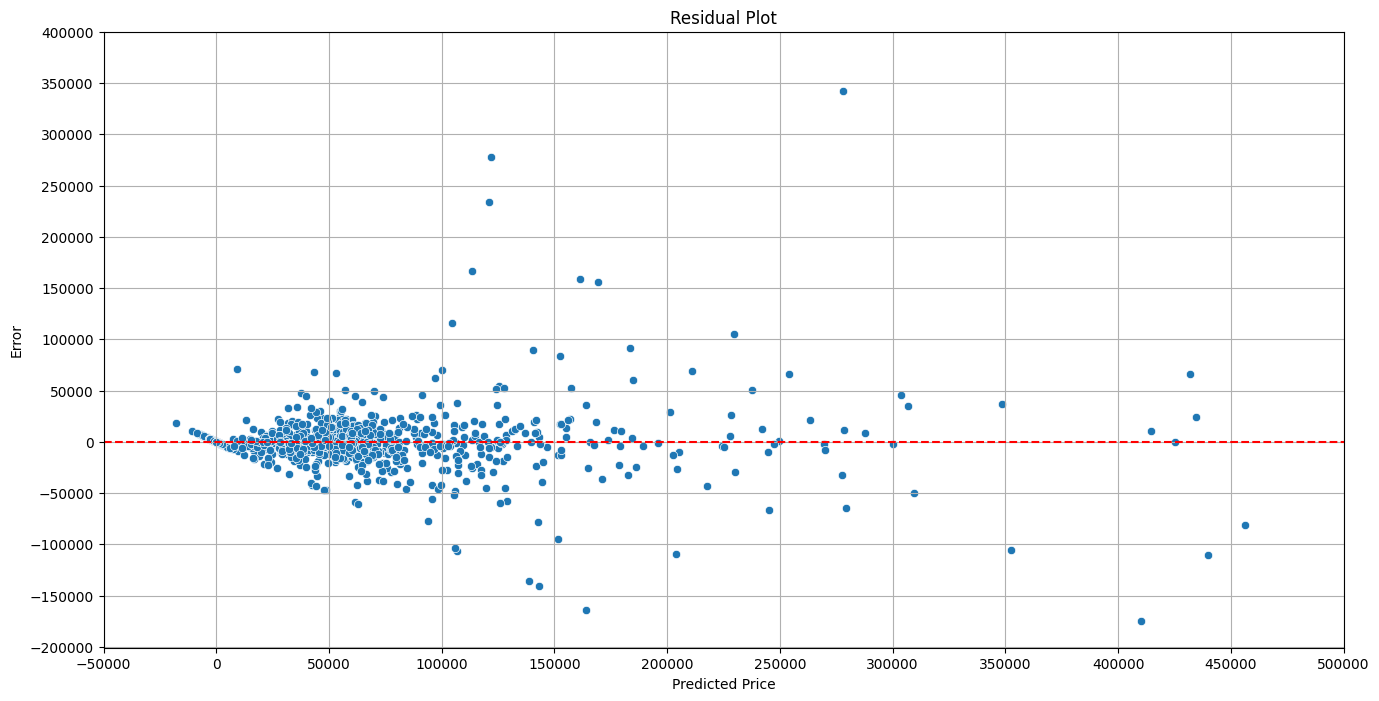

In [30]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=y_pred_tuned, y=error)
plt.xlabel('Predicted Price')
plt.ylabel('Error')
plt.title('Residual Plot')
plt.grid(True)
plt.xticks(range(-50000,500001,50000))
plt.yticks(range(-200000,400001,50000))
plt.axhline(y=0, color='r', linestyle='--');

#### **Insights:**
1. The variance of predicted prices is not constant throughout.
2. The errors are greater at higher predicted prices.
3. There is no obvious pattern to the residual plot.
    - Another good indication that the model is a good fit.

### **3. Residual Distribution Plot**

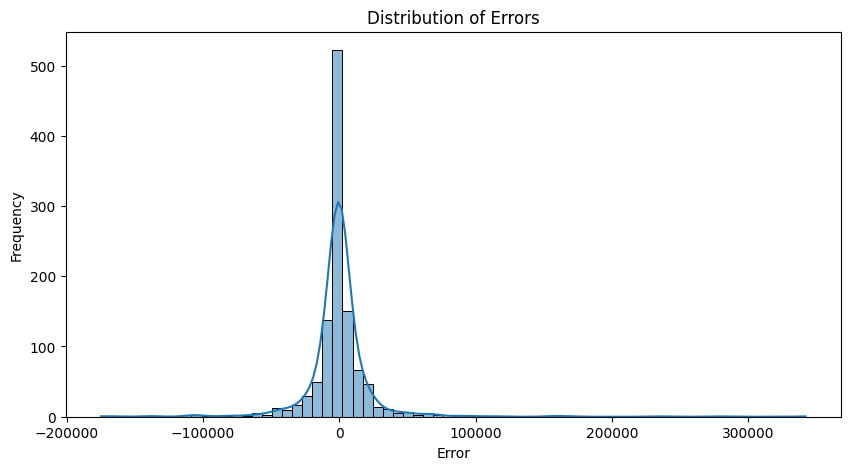

In [32]:
plt.figure(figsize=(10,5))
sns.histplot(error, kde=True,bins=70)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Errors');

#### **Insights:**
1. The errors are not normally distributed.
2. The errors tend to deviate towards the negative.
    - This means that the predicted prices are slightly higher than the actual price.

## **Conclusion**
### **Interpretation**
1. R-squared score: 0.8193
    - The model is capable of explaining approximately 81.93% of the variance of the price.
    - The model represents a reasonably strong fit between the features and the price.
2. MAE: $11,803
    - The average error of the model's ability to predict price is $11,803.
    - Considering that the price ranges from $0 to $850,000, the error is relatively small.
3. RMSE: $26,988
    - The average prediction error of the model is $26,988.
    - This error is also relatively small considering the price ranges.
4. Actual vs Predicted
    - The model is capable of predicting prices accurately.
    - The model is generates more errors at prices above $200,000.
5. Residual Analysis
    - The errors tend to deviate towards the negative. This means that the model's prediction is higher than the actual price.
    - The variance of the residuals are not constant, and there is no obvious pattern in the residual plot. This means that the model is<br> capable of predicting prices accurately.
### **Is the model accurate and acceptable?**
**Yes, the model is accurate and acceptable.** The model has a relatively high fit score, and it has a relatively low error compared to the price ranges, which means that the model can accurately predict the prices with minimum error. Furthermore, the predicted prices are higher than the actual prices. From a business standpoint, this may be beneficial, because it means that the used cars are sold at a slightly higher price, which may lead to an increase in profits. <br>
<br>
**However, the model may not be acceptable at higher prices above $200,000.** This is so because the model generates higher errors after the stated price. From a business standpoint, this may lead to significant losses in profits.

## **Recommendations**

To improve on the model, there are some recommendations to be made:
1. Add more features that have a stronger correlation to price, for example: **fuel economy (km/L), interior**, etc. 
    - Only the feature "Negotiable" has a strong correlation with price.
    - Other features have a weak to moderate correlation.
2. Try using regularisation techniques, such as L1 and L2 regularisation, to prevent model overfitting.
    - Overfitting occurs when the model has a high accuracy on the training set, but a low accuracy on the testing set, which leads to inaccuracies in predicting the prices.
3. Experiment with more hyperparameters in the algorithm, to reduce errors in the model.
    - Aim to also decrease the error's tendency to the positive or negative.
4. Collect more data on cars with higher prices.
    - The model is not that accurate at higher prices. This is so because of insufficient data in the upper end of prices.

## **Saving Model**

In [25]:
# tuned algorithm
xgbtuned = XGBRegressor(learning_rate=0.01, max_depth=12, min_child_weight=10, n_estimators=1000, subsample=0.8)

# tuned model
model_final = Pipeline([
    ('preprocessing', transformer),
    ('modeling', xgbtuned)
])

# fitting
model_final.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['Type', 'Region', 'Make']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['Gear_Type', 'Origin',
                                                   'Negotiable']),
                                                 ('ordinal',
                                                  OrdinalEncoder(cols=['Options'],
                                                                 mapping=[{'col': 'Options',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Standard     1
Semi Full    2
Full         3
dtype: int64}]),
                                                  ['Opti...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=12, max_leaves=None,
                              min_child_weight=10, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [26]:
import pickle
pickle.dump(model_final, open('Best_Model_Pickled.sav', 'wb'))

Note for PPT:
- explain how the metrics of evaluation and modeling work